### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

# README

All the information is included in the notebook, which is commented. **Needs GPU to be executed**

The notebook includes our work for the task 1, with the two approaches: with and without pre-trained embeddings.

The first approach presents those models:
- FunConv: a hand-made simple convolutional+MLP architecture, which uses GloVe-100 embeddings.
- BiLSTM.
- BERT.

The second approach is composed of a pipeline of TF-IDF (features), PCA (dimensionality reduction) and XGBoost (for regression).

All the models perform and describe their own data pre-processing.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Imperial (TP et CW term 2)/NLP/Coursework/'
path = '/content/'

!gdown --id 1UgrdjcHHZmAthjusQDAKoSqd37up-41f
!gdown --id 1rY6A0cN_cxAMK3aMHlTFWxhbcLFomvQL

Downloading...
From: https://drive.google.com/uc?id=1UgrdjcHHZmAthjusQDAKoSqd37up-41f
To: /content/train.csv
100% 948k/948k [00:00<00:00, 14.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rY6A0cN_cxAMK3aMHlTFWxhbcLFomvQL
To: /content/dev.csv
100% 219k/219k [00:00<00:00, 7.08MB/s]


In [ ]:
# You will need to download any word embeddings required for your code, e.g.:

#%cd /content/drive/MyDrive/Imperial (TP et CW term 2)/NLP/Coursework/
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

--2021-03-01 21:53:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-01 21:53:56--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-01 21:53:56--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

# Approach 1


##FunConv : a simple CNN

### Set up

In [ ]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs

In [ ]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, loss_fn):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    
    print("Training model.")

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:

            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            no_observations = no_observations + target.shape[0]

            predictions = model(feature).squeeze(1)

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)
            #print(f'The loss is {loss.item()}')

            loss.backward()
            optimizer.step()

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.5f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

In [ ]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            no_observations = no_observations + target.shape[0]

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

### Pre-processing

We pre-process our data, by tokenizing it with respect to spaces. We also remove left and right leading spaces, and we apply lowercasing to all the sentences.

In [ ]:
import re
import string

def clean_tok(inp):
    sentence_wo_lspaces = inp.strip().lower() #remove left and right leading spaces + lowercase
    clean_wo_lspaces_numbers = sentence_wo_lspaces #remove numbers is useless, it will not appear in pre-trained embeddings
    clean_sentence = clean_wo_lspaces_numbers

    clean_sentence_tokenized = []
    for token in clean_sentence.split(" "):
        clean_sentence_tokenized.append(token)

    return clean_sentence_tokenized

def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    tokenized_replaced = []
    tokenized_edits = []

    for row in data:

        if data.ndim > 1:
            #clean the data (preprocessing) before tokenization
            tokenized_corpus.append(clean_tok(row[0]))
            tokenized_replaced.append(clean_tok(row[1]))
            tokenized_edits.append(clean_tok(row[2]))

        else:
            tokenized_corpus.append(clean_tok(row))

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                if True:
                    vocabulary.append(token)
    if data.ndim > 1:
        for sentence in tokenized_replaced:
            for token in sentence:
                if token not in vocabulary:
                    if True:
                        vocabulary.append(token)
        for sentence in tokenized_edits:
            for token in sentence:
                if token not in vocabulary:
                    if True:
                        vocabulary.append(token)

    return vocabulary, tokenized_corpus, tokenized_replaced, tokenized_edits

The padding is operated in the collate_fn_padd() function: we pad with 0 the sentences (which are the original headlines).

In [ ]:
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    ## get sequence lengths
    lengths = torch.tensor([ t.shape[0] for t in batch_features ])

    ## pad
    batch_features = [ torch.LongTensor(t) for t in batch_features ]
    batch_features = torch.nn.utils.rnn.pad_sequence(batch_features, padding_value=0, batch_first=True)
    return torch.LongTensor(batch_features), torch.FloatTensor(batch_labels)

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

### Model

The model is a simple convolutional neural network, taking as an input the encoded sentences (headlines), the modified word and the modifying word. Then, it applies the pre-trained embedding (here, GloVe embeddings of size 100) and a convolutional layer. Then, FC layers serve the regression task.

In [ ]:
import torch.nn.functional as F

class FunConv(nn.Module): # A simple convolutional model

    def __init__(self, embedding_dim, vocab_size, device):

        super(FunConv, self).__init__()
        self.train()

        self.device = device
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 1))

        self.fc1 = nn.Linear(in_features=8*embedding_dim, out_features=16)
        self.fc2 = nn.Linear(16, 1)


    def forward(self, sentence):

        batch_size = sentence.shape[0]
        sentence = sentence.unsqueeze(1) #(B, 1, N)
        embedded = self.embedding(sentence) #(B, 1, N, EMB_DIM)

        #embedded of shape (B, N, EMB_DIM)

        mask = (embedded[:,:,2:,:] != 0)*1.0
        embedded[:,:,2] = torch.sum(embedded[:,:,2:,:], dim=2) / torch.sum(mask, dim=2)
        embedded = embedded[:,:,0:3,:] #remove all the rest of the cols

        out = F.elu(self.conv1(embedded))

        out = torch.flatten(out, start_dim=1)

        out = F.elu(self.fc1(out))
        out = 3.0*torch.sigmoid(self.fc2(out))
        #out = F.relu(self.fc2(out))

        return out

### Train, metrics, performances

In [ ]:
## Approach 1 code, using functions defined above:

# Number of epochs
epochs = 10
# Proportion of training data for train compared to dev
train_proportion = 0.80

# Load data
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'dev.csv')

# To work on small subset of the dataset
#train_df = train_df.head(50)
#test_df = test_df.head(50)

# Parse the relevant features
replaced_words = []
sentences = []
for s in train_df['original'].tolist():
    start = s.find('<') + 1
    end = s.find('/>', start)
    replaced_words.append(s[start:end])
    s = s.replace('<','')
    s = s.replace('/>','')  
    sentences.append(s)
train_df['replaced_word'] = replaced_words
train_df['original'] = sentences

replaced_words = []
sentences = []
for s in test_df['original'].tolist():
    start = s.find('<') + 1
    end = s.find('/>', start)
    replaced_words.append(s[start:end])
    s = s.replace('<','')
    s = s.replace('/>','')  
    sentences.append(s)
test_df['replaced_word'] = replaced_words
test_df['original'] = sentences


# We set our training data and test data
training_data = np.array(train_df[['original', 'replaced_word', 'edit']])
test_data = np.array(test_df[['original', 'replaced_word', 'edit']])

# Creating word vectors
training_vocab, training_tokenized_corpus, training_tokenized_replaced, training_tokenized_edits = create_vocab(training_data)
test_vocab, test_tokenized_corpus, test_tokenized_replaced, test_tokenized_edits = create_vocab(test_data)

# Creating joint vocab from test and train:
joint_vocab,_ ,_, _ = create_vocab(np.concatenate([training_data.flatten(), test_data.flatten()]))

print("Vocab created.")

# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

missing_word_stats = {}

# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.100d.txt', 'r','utf-8') as f:
  index = 1 #0 is for padding
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

print(np.array(wvecs).shape)

#wvecs = np.concatenate((np.zeros((1,100)), np.array(wvecs), np.random.randn(2,100)), axis=0) #inserted new words
wvecs = np.concatenate((np.zeros((1,100)), np.array(wvecs)), axis=0)
word2idx = dict(word2idx)
word2idx['<pad>'] = 0
#word2idx['brexit'] = index
#word2idx['daca'] = index+1
idx2word = dict(idx2word)
idx2word[0] = '<pad>'
#idx2word[index] = "brexit"
#idx2word[index+1] = "daca"


print("Embeddings loaded.")

# Populate a list of unknown words
for i in range(len(training_tokenized_corpus)):
    for k in training_tokenized_replaced[i]:
        if k not in word2idx:
            missing_word_stats[k] = missing_word_stats.get(k, 0) + 1
    for k in training_tokenized_edits[i]:
        if k not in word2idx:
            missing_word_stats[k] = missing_word_stats.get(k, 0) + 1
    for k in training_tokenized_corpus[i]:
        if k not in word2idx:
            missing_word_stats[k] = missing_word_stats.get(k, 0) + 1

vectorized_seqs = []
for i in range(len(training_tokenized_corpus)):
    vectorized_seqs.append([word2idx[tok] if tok in word2idx else 0 for tok in training_tokenized_replaced[i]] + [word2idx[tok] if tok in word2idx else 0 for tok in training_tokenized_edits[i]] + [word2idx[tok] if tok in word2idx else 0 for tok in training_tokenized_corpus[i]])

# To avoid any sentences being empty (if no words match to our word embeddings)
def clean_vec(vectorized_seqs, labels):
    y = []
    cleaned = []
    for i, x in enumerate(vectorized_seqs):
        if len(x) == 0 or x[0] == 0 or x[1] == 0 or sum(x[2:]) == 0:
            continue
        cleaned.append(np.array(x))
        y.append(labels[i])
    y = np.array(y)
    assert len(cleaned) == y.shape[0]
    return cleaned, y

vectorized_seqs, mean_grades = clean_vec(vectorized_seqs, train_df['meanGrade'])

INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
BATCH_SIZE = 32

#Inputs vectorized.

model = FunConv(EMBEDDING_DIM, INPUT_DIM, device)
print("Model initialised.")

model.to(device)

# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens : CONVERTED TO NP.ARRAY
train_and_dev = Task1Dataset(feature, mean_grades)

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=10e-5)

train(train_loader, dev_loader, model, epochs, loss_fn)

Vocab created.
(11803, 100)
Embeddings loaded.
Model initialised.
Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.34549 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.32 | Val. MSE: 0.32 |  Val. RMSE: 0.57 |
| Epoch: 02 | Train Loss: 0.31746 | Train MSE: 0.32 | Train RMSE: 0.56 |         Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
| Epoch: 03 | Train Loss: 0.30805 | Train MSE: 0.31 | Train RMSE: 0.56 |         Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
| Epoch: 04 | Train Loss: 0.30152 | Train MSE: 0.30 | Train RMSE: 0.55 |         Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
| Epoch: 05 | Train Loss: 0.29568 | Train MSE: 0.30 | Train RMSE: 0.54 |         Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
| Epoch: 06 | Train Loss: 0.28968 | Train MSE: 0.29 | Train RMSE: 0.54 |         Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.55 |
| Epoch: 07 | Train Loss: 0.28328 | Train MSE: 0.28 | Train RMSE: 0.53 |         Val. L

In [ ]:
print("The unknown words:")
print(dict(sorted(missing_word_stats.items(), key=lambda item: item[1], reverse=True)))

The unknown words:
{'brexit': 47, 'daca': 39, 'anti-trump': 28, 'trump-russia': 26, 'scaramucci': 18, 'trumpcare': 18, 'reince': 11, 'alt-right': 11, 'trump-era': 9, 'pro-trump': 9, '#metoo': 9, 'alt-left': 9, 'puzder': 9, 'at&amp;t': 8, 'co-opts': 8, 'gianforte': 7, 'shithole': 6, 'kushners': 6, 'bush-era': 6, 'wapo': 6, 'cnnpolitics.com': 6, 'selfie': 5, 'greitens': 5, 'selfies': 5, 'cryptocurrency': 5, 'shipworm': 5, 'dotards': 4, 'dotard': 4, 'chibok': 3, 'harder-line': 3, 'affirmative-action': 3, 'assault-style': 3, 'process-related': 3, 'picture-perfect': 3, 'schlapp': 3, 'medicare-for-all': 3, 'manassian': 3, 'satellite-carrying': 3, 'deplorableness': 3, 'tipline': 3, 'lie-detector': 3, 'ukraines': 3, 'russia-us': 3, 'party-switch': 3, 'kasich-hickenlooper': 3, 'street-friendly': 3, 'delingpole': 3, 'pocohontas': 3, 'trump-palin-nugent-kid': 3, 'aecon': 3, '300mw': 3, 'ex-pm': 3, '#war': 3, 'mega-colonies': 3, 'mcenany': 3, 'q&amp;a': 3, 'subreddit': 3, 'cyberweapons': 3, 'warmb

In [ ]:
nz = 0
z = 0
for sentence in vectorized_seqs:
    for code in sentence:
        if code == 0:
            z += 1
        nz += 1
print("The proportion of unknown words")
print(z/nz) # The proportion of unknown words

The proportion of unknown words
0.0072776162153472945


In [ ]:
# This cell is for the inference on test set

'''vectorized_seqs_infer = []
for i in range(len(test_tokenized_corpus)):
    vectorized_seqs_infer.append([word2idx[tok] if tok in word2idx else 0 for tok in test_tokenized_replaced[i]] + [word2idx[tok] if tok in word2idx else 0 for tok in test_tokenized_edits[i]] + [word2idx[tok] if tok in word2idx else 0 for tok in test_tokenized_corpus[i]])

# To avoid any sentences being empty (if no words match to our word embeddings)
def clean_vec_infer(vectorized_seqs, ids):
    cleaned = []
    ids_out = []
    ids_not_selected = []
    for i, x in enumerate(vectorized_seqs):
        if len(x) == 0 or x[0] == 0 or x[1] == 0 or sum(x[2:]) == 0:
            ids_not_selected.append(ids[i])
            continue
        cleaned.append(np.array(x))
        ids_out.append(ids[i])
    return cleaned, ids_out, ids_not_selected


vectorized_seqs_infer, ids_out, ids_not_selected = clean_vec_infer(vectorized_seqs_infer, test_df['id'])
infer_dataset = Task1Dataset(vectorized_seqs_infer, np.zeros(len(vectorized_seqs_infer)))
infer_loader = torch.utils.data.DataLoader(infer_dataset, batch_size=1, collate_fn=collate_fn_padd)

model.eval()
predictions = []

for ele,_ in list(infer_loader):
    ele = ele.to(device)
    predictions.append(model(ele)[0, 0].item())

df_id = pd.DataFrame({'id': ids_out})
df_pred = pd.DataFrame({'pred': predictions})

res = pd.concat([df_id, df_pred], axis=1)

## Add baseline for lines that have been deleted during cleaning 0.9355712114932938

for id in ids_not_selected:
    res = res.append({"id": id, "pred": 0.9355712114932938}, ignore_index=True)

res['id'] = res['id'].astype(int)'''

#res.to_csv(path + 'out.csv', index=False, sep=',')

'vectorized_seqs_infer = []\nfor i in range(len(test_tokenized_corpus)):\n    vectorized_seqs_infer.append([word2idx[tok] if tok in word2idx else 0 for tok in test_tokenized_replaced[i]] + [word2idx[tok] if tok in word2idx else 0 for tok in test_tokenized_edits[i]] + [word2idx[tok] if tok in word2idx else 0 for tok in test_tokenized_corpus[i]])\n\n# To avoid any sentences being empty (if no words match to our word embeddings)\ndef clean_vec_infer(vectorized_seqs, ids):\n    cleaned = []\n    ids_out = []\n    ids_not_selected = []\n    for i, x in enumerate(vectorized_seqs):\n        if len(x) == 0 or x[0] == 0 or x[1] == 0 or sum(x[2:]) == 0:\n            ids_not_selected.append(ids[i])\n            continue\n        cleaned.append(np.array(x))\n        ids_out.append(ids[i])\n    return cleaned, ids_out, ids_not_selected\n\n\nvectorized_seqs_infer, ids_out, ids_not_selected = clean_vec_infer(vectorized_seqs_infer, test_df[\'id\'])\ninfer_dataset = Task1Dataset(vectorized_seqs_infer, 

##BiLSTM

In [ ]:
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'dev.csv')
words = []
sentences = []
edited_sentences = []
concat = []
fromto = []
i = 0
for s in train_df['original'].tolist():
  edit = train_df['edit'].tolist()[i]
  i += 1
  start = s.find('<') + 1
  end = s.find('/>', start)
  word = s[start:end]
  words.append(word)
  s = s.replace('<','')
  s = s.replace('/>','')  
  edit_s = s.replace(word,edit)
  sentences.append(s)
  edited_sentences.append(edit_s)
  concat.append(s + '. ' + edit_s)
  fromto.append('From ' + word + ' to ' + edit)


train_df['original_word'] = words
train_df['original'] = sentences
train_df['edit_sentence'] = edited_sentences
train_df['concat'] = concat
train_df['FromTo'] = fromto


words = []
sentences = []
edited_sentences = []
concat = []
fromto = []
i = 0
for s in test_df['original'].tolist():
  edit = test_df['edit'].tolist()[i]
  i += 1
  start = s.find('<') + 1
  end = s.find('/>', start)
  word = s[start:end]
  words.append(word)
  s = s.replace('<','')
  s = s.replace('/>','')  
  edit_s = s.replace(word,edit)
  sentences.append(s)
  edited_sentences.append(edit_s)
  concat.append(s + '. ' + edit_s)
  fromto.append('From ' + word + ' to ' + edit)

test_df['original_word'] = words 
test_df['original'] = sentences
test_df['edit_sentence'] = edited_sentences
test_df['concat'] = concat
test_df['FromTo'] = fromto

In [ ]:
# Number of epochs
epochs = 5

# Proportion of training data for train compared to dev
train_proportion = 0.8

def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    
    print("Training model.")
    
    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far
        
        y_pred = np.array([])
        y_true = np.array([])

        for batch in train_iter:
            
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list

    for sentence in data:

        tokenized_sentence = []

        for token in sentence.split(' '): # simplest split is

            tokenized_sentence.append(token)

        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        try:
          embedded = self.embedding(sentence)
        except:
          print("PROBLEM")
          print(sentence.shape)
          print(sentence)
        embedded = embedded.permute(1, 0, 2)

        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

        out = self.hidden2label(lstm_out[-1])
        return out

In [ ]:
training_data = train_df['FromTo']
test_data = test_df['FromTo']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))
print("Vocab created.")

wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

EMBEDDING_DIM = 100
embed_glove = 'glove.6B.{}d.txt'.format(EMBEDDING_DIM)

# Add word 0 to vocab to keep good indexes
word2idx.append(('<pad>',0))
idx2word.append((0,'<pad>'))
wvecs.append(np.zeros(EMBEDDING_DIM))

with codecs.open(embed_glove, 'r','utf-8') as f:
  index = 1
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

INPUT_DIM = len(word2idx)
BATCH_SIZE = 32

model = BiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 10
train(train_loader, dev_loader, model, epochs)

Vocab created.
Model initialised.
Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.78 | Train MSE: 0.78 | Train RMSE: 0.88 |         Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 |
| Epoch: 02 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.33 | Val. MSE: 0.33 |  Val. RMSE: 0.57 |
| Epoch: 03 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.57 |         Val. Loss: 0.32 | Val. MSE: 0.32 |  Val. RMSE: 0.56 |
| Epoch: 04 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.57 |         Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
| Epoch: 05 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.56 |         Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
| Epoch: 06 | Train Loss: 0.31 | Train MSE: 0.31 | Train RMSE: 0.56 |         Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.55 |
| Epoch: 07 | Train Loss: 0.31 | Train MSE: 0.31 | Train RMSE: 0.55 |         Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.55 |
| Epo

##BERT Transformer

In [ ]:
!pip install transformers==3.0.0

     |████████████████████████████████| 757kB 16.6MB/s 
     |████████████████████████████████| 3.0MB 39.9MB/s 
     |████████████████████████████████| 1.2MB 55.3MB/s 
     |████████████████████████████████| 890kB 47.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=fd371f05a7d1e3e7e9f72d701b41663a0e7580bf9ad1c6e0bc47eec707de90d6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Loading of train and val set, tokenization of our dataset with pretrained BERT tokenizer

In [ ]:
from transformers import BertTokenizer
import torch
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.2)

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

# Get the lists of sentences and their labels.
sentences = train['edit_sentence'].values
labels = train['meanGrade'].values

# Tokenize all of the sentences and map the tokens to thier word IDs.

input_ids = []
attention_masks = []

input_ids_val = []
attention_masks_val = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 32,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

sentences_val = val['edit_sentence'].values
labels_val = val['meanGrade'].values

input_ids_val = []
attention_masks_val = []

for sent in sentences_val:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 32,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True
                   )
    input_ids_val.append(encoded_dict['input_ids'])    
    attention_masks_val.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_val = torch.cat(input_ids_val, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
labels_val = torch.tensor(labels_val)

sentences_test = test_df['edit_sentence'].values

input_ids_test = []
attention_masks_test = []

for sent in sentences_test:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 32,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True
                   )
    input_ids_test.append(encoded_dict['input_ids'])    
    attention_masks_test.append(encoded_dict['attention_mask'])

input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

Creation of our TensorDataset and DataLoaders

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataset = TensorDataset(input_ids, attention_masks, labels)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dev_dataset = TensorDataset(input_ids_test, attention_masks_test)
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

dev_dataloader = DataLoader(
            dev_dataset, # The validation samples.
            sampler = SequentialSampler(dev_dataset), # Pull out batches sequentially.
            batch_size = len(dev_dataset) # Evaluate with this batch size.
        )


Initialization of our BertForSequenceClassification model(regression because num_labels = 1)

In [ ]:
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
import random
 
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 1,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.cuda()
model = model.double()
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Using cuda


Custom train and eval functions for BERT model

In [ ]:
def eval_BERT(data_iter, model):
    print("Running Validation...")
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    y_pred = np.array([])
    y_true = np.array([])

    # Evaluate data for one epoch
    for batch in data_iter:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
 
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_pred = np.append(y_pred,logits)
        y_true = np.append(y_true,label_ids)
    sse, mse = model_performance(y_pred, y_true)

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    return avg_val_loss, mse, y_pred, y_true


def train_BERT(train_iter, dev_iter, model, number_epoch):
    for epoch_i in range(1, number_epoch+1):        

        total_train_loss = 0
        train_mse = 0
        model.train()
        y_pred = np.array([])
        y_true = np.array([])

        for step, batch in enumerate(train_iter):
            # if step % 40 == 0 and not step == 0:
            #     print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_iter)))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        

            loss, logits = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            y_pred = np.append(y_pred,logits)
            y_true = np.append(y_true,label_ids) 

            total_train_loss += loss.item()

            loss.backward()

            # Clip the norm of the gradients to 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()
        _, train_mse = model_performance(y_pred, y_true) 
        avg_train_loss = total_train_loss / len(train_iter) 
        valid_loss, valid_mse, __, __ = eval_BERT(dev_iter, model)
        print(f'| Epoch: {epoch_i:02} | Train Loss: {avg_train_loss:.2f} | Train MSE: {train_mse:.2f} | Train RMSE: {train_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

Training of BERT model

In [ ]:
train_BERT(train_dataloader, validation_dataloader, model, epochs)

Running Validation...
| Epoch: 01 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.29 | Val. MSE: 0.29 |  Val. RMSE: 0.54 |
Running Validation...
| Epoch: 02 | Train Loss: 0.29 | Train MSE: 0.29 | Train RMSE: 0.53 |         Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.55 |
Running Validation...
| Epoch: 03 | Train Loss: 0.23 | Train MSE: 0.23 | Train RMSE: 0.48 |         Val. Loss: 0.30 | Val. MSE: 0.31 |  Val. RMSE: 0.55 |


# **Approach 2** 

Bellow, no embedded representations or pre trained models are used.

This approach is based on the assumption that the funny aspect of the data set relies on how absurd it is to find the edited word in the provided context.
The chosen inputs are the full original headlines (without tokens) and the edited version of the headlines. After some pre-processing, we compute a TF-IDF representation of the inputs and perform dimensionality reduction with PCA. Finally, a gradient based regressor, namely XGboost regressor, is tuned and trained to predict the grades.

## Set up


In [ ]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs

import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Setting random seed and device
SEED = 2

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## Reload data




Here, the data is read and the distribution of the mean grade is plotted, we can see that most headlines have grades lower than 2.

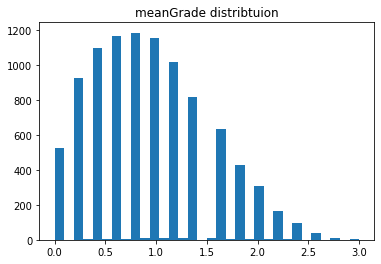

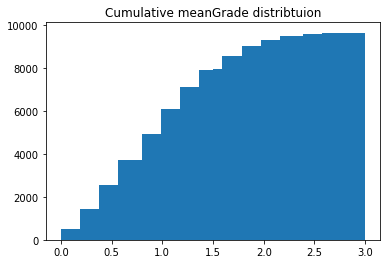

In [ ]:
# Read data
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'dev.csv')

# Plot the data distribution
import matplotlib.pyplot as plt
plt.hist(train_df['meanGrade'], bins= 32, cumulative=False)
plt.title("meanGrade distribtuion")
plt.show()
plt.hist(train_df['meanGrade'], bins= 64, cumulative=True)
plt.title("Cumulative meanGrade distribtuion")
plt.show()

## Pre-processing

We remove the tags from the headlines and create different dictionnaries. Each one encapsulates a version of the data: the edited work, the original sentence without the word to edit, the original word that was used to be edited etc.
Even though all of them are not used in this notebook, we compared the performance of the regression obtained from different combinations of them and kept the one that led to the lowest RMSE. This combination is made of the original sentence (with the tag of the word to edit removed) and the edited verrsion of the sentence.

In [ ]:


###### identify and remove tags for the word to edit ######
##### create different dictionaries depending on the information we keep ######
def remove_edit_tags(corpus):  
  words = []
  full_sentences = []
  context_sentences = []
  edited_sentences = []
  for i, s in enumerate(corpus['original'].tolist()):
    start = s.find('<') + 1
    end = s.find('/>', start)
    words.append(s[start:end])
    s = s.replace('<','')
    s = s.replace('/>','')  
    full_sentences.append(s)
    context_sentences.append(s[:start-1]+s[end:])
    edited_sentences.append(s[:start-1]+corpus['edit'][i] + " " + s[end:])
  corpus['original_word'] = words
  corpus['original'] = full_sentences
  corpus['context'] = context_sentences
  corpus['edited_sentences'] = edited_sentences
  return(corpus)

print("** Original sentence: **")
print(train_df['original'][1])

train_no_edited_tags = remove_edit_tags(train_df)
test_no_edited_tags = remove_edit_tags(test_df)

print("\n** Example of a pair of sentences after tag removal: **")
print(train_no_edited_tags['original'][1])
print(train_no_edited_tags['edited_sentences'][1])




####### Split for trainig and valdiation 80/20 and creates features
indices = np.arange(0, len(train_df)) 
np.random.shuffle(indices)
train_idx = indices[:int(0.8*len(train_df))]
val_idx = indices[int(0.8*len(train_df)):] 

# training set with original and edited sentences
x_train = [train_df['original'][train_idx].tolist(), train_df['edited_sentences'][train_idx].tolist()]
y_train = train_df['meanGrade'][train_idx].tolist()
y_train = np.array(y_train)

# validation set with original and edited sentences
x_val = [train_df['original'][val_idx].tolist(), train_df['edited_sentences'][val_idx].tolist()]
y_val = train_df['meanGrade'][val_idx].tolist()
y_val = np.array(y_val)





** Original sentence: **
Pentagon claims 2,000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?

** Example of a pair of sentences after tag removal: **
Pentagon claims 2,000 % increase in Russian trolls after Syria strikes . What does that mean ?
Pentagon claims 2,000 % increase in Russian trolls after bowling strikes . What does that mean ?


In the cell bellow, the sentences are processed before being transformed in the TF IDF representation.

Because no embedded representation is used, we work on the full sentences to keep as much information as possible. However, stop words and regexp allows us to get rid of words or symbols that do not carry a relevant meaning. The data set being small, lemmatization helps the model to identify similar words and group them together in the counts. All sentences become lower-case in order to have a consistant format. Not all headlines of the corpus are capitalized. 


In [ ]:
############# TF IDF #############

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stopword = stopwords.words('english')
stopword += ['s', "'"]





# tokenizer + lemmatization + lowercase + stop words + number removal
def home_tokenizer(sentence):
  t = []
  # Tokenize + lowercase
  tokens = word_tokenize(sentence.lower())
  # Stop words + Lemmatization
  for word in tokens:
    # regexp to remove numbers
    word = re.sub(r"\d+[.,]*[0-9]+", "", word)
    if word not in stopword and len(word)>1:
      t.append(lemmatizer.lemmatize(word))
  return t


print("\n\nExample of the home_tokenizer function:")
print("original",word_tokenize(x_train[0][0]))
print("home_tokenizer",home_tokenizer(x_train[0][0]))




##### Train Tf-idf model #####

count_vect = CountVectorizer(stop_words=None, tokenizer=home_tokenizer, ngram_range=(1,1)) 

# fit original to Tf-idff 
train_original_counts = count_vect.fit_transform(x_train[0])
transformer = TfidfTransformer().fit(train_original_counts)
train_original_counts = transformer.transform(train_original_counts).toarray()

# transform edited sentences to tf-idf 
train_edit_counts = count_vect.transform(x_train[1])
train_edit_counts = transformer.transform(train_edit_counts).toarray()




##### Validation Tf-idf model #####

# fit original to Tf-idff,  on all the training set
train_and_val_original_counts = count_vect.transform(train_df['original'])
transformer = TfidfTransformer().fit(train_and_val_original_counts)
val_original_counts = count_vect.transform(x_val[0])
val_original_counts = transformer.transform(val_original_counts).toarray()

# # transform edited sentences to tf-idf
val_edit_counts = count_vect.transform(x_val[1])
val_edit_counts = transformer.transform(val_edit_counts).toarray()



##### Test Tf-idf model #####

# fit original to Tf-idff,  on all the data set (train and test)
test_original_counts = count_vect.transform( pd.concat([train_df['original'], test_df['original']]))
transformer = TfidfTransformer().fit(test_original_counts)
test_original_counts = count_vect.transform(test_df['original'])
test_original_counts = transformer.transform(test_original_counts).toarray()

# transform edited sentences to tf-idf
test_edit_counts = count_vect.transform(test_df['edited_sentences'])
test_edit_counts = transformer.transform(test_edit_counts).toarray()





##### create final train and validation sets that can be fed to the regressor#####

# final training set
x_final_train = np.concatenate( (train_original_counts, train_edit_counts), axis=1 )

# final validation set
x_final_val = np.concatenate( (val_original_counts, val_edit_counts), axis=1 )


##### create final test set to be fed to the regressor#####
x_final_test = np.concatenate( (test_original_counts, test_edit_counts), axis=1 )

print(x_final_train.shape)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Example of the home_tokenizer function:
original ['Trump', 'Administration', 'Rolls', 'Back', 'Rules', 'Protecting', 'Transgender', 'Inmates']
home_tokenizer ['trump', 'administration', 'roll', 'back', 'rule', 'protecting', 'transgender', 'inmate']
(7721, 12914)


## Model


Baseline of the model

Baseline

| MSE: 0.34 | RMSE: 0.58 |

## Evaluate performance

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

The features of our final vectors are the concatenation of TF-IDF representation of two sentences that are very close to each other. PCA is performed to alleviate redundancy while keeping 99% of explained variance. Also,dimensionaility reduction makes the regressor work faster.

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components = 0.99)
scaler = StandardScaler()

# Normalize the data and fit PCA
scaler.fit(x_final_train)
x_final_train = scaler.transform(x_final_train)
pca.fit(x_final_train)
Xtrain = pca.transform(x_final_train)

x_final_val = scaler.transform(x_final_val)
Xval = pca.transform(x_final_val)

print("Shape before PCA :")
print("x_final_train shape: ", x_final_train.shape)
print("x_final_train val: ", x_final_val.shape)

print("\n\nShape after PCA :")
print("Xtrain shape: ", Xtrain.shape)
print("Xval shape: ", Xval.shape)


Shape before PCA :
x_final_train shape:  (7721, 12914)
x_final_train val:  (1931, 12914)


Shape after PCA :
Xtrain shape:  (7721, 3994)
Xval shape:  (1931, 3994)


Use XGboost regressor with tuned parameters.

In [31]:
# test
import xgboost as xg 

eval_set = [(Xtrain, y_train), (Xval, y_val)]

# model
xgb_r = xg.XGBRegressor(n_estimators=300, verbosity=1, max_depth=3, gamma = 0.01,
                        colsample_bytree=1, reg_alpha=0.1, reg_lambda = 1,
                        learning_rate = 0.05) 
 
# Fitting the model 
print(Xtrain.shape)
xgb_r.fit(Xtrain, y_train, eval_set= eval_set, early_stopping_rounds=30) 
  
# Predict the model 
pred_train = xgb_r.predict(Xtrain) 
pred_val = xgb_r.predict(Xval)




(7721, 3994)
[22:49:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.718072	validation_1-rmse:0.701599
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:0.705623	validation_1-rmse:0.689667
[2]	validation_0-rmse:0.694096	validation_1-rmse:0.678576
[3]	validation_0-rmse:0.683533	validation_1-rmse:0.668503
[4]	validation_0-rmse:0.673798	validation_1-rmse:0.659053
[5]	validation_0-rmse:0.664837	validation_1-rmse:0.650493
[6]	validation_0-rmse:0.656625	validation_1-rmse:0.642719
[7]	validation_0-rmse:0.649082	validation_1-rmse:0.635508
[8]	validation_0-rmse:0.642142	validation_1-rmse:0.629004
[9]	validation_0-rmse:0.635723	validation_1-rmse:0.623359
[10]	validation_0-rmse:0.62986	validation_1-rmse:0.617767
[11]	validation_0-rmse:0.624462	validation_1-rmse:0.612592
[12]

Plot the learning curves


Train performance:
| MSE: 0.26 | RMSE: 0.51 |

Dev performance:
| MSE: 0.32 | RMSE: 0.56 |


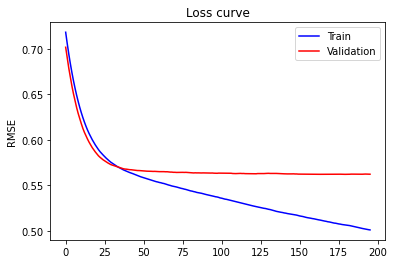

In [32]:
# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(pred_train, y_train, True)

print("\nDev performance:")
sse, mse = model_performance(pred_val, y_val, True)


# retrieve performance metrics
results = xgb_r.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
plt.plot(x_axis, results['validation_0']['rmse'], color = 'b', label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], color = 'r', label='Validation')
plt.legend()
plt.ylabel('RMSE')
plt.title('Loss curve')
plt.show()
